In [7]:
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
from scipy import stats
import math
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_PATH = Path("/project/greencenter/Toprak_lab/shared/TEM1_Combinatorial_Mutagenesis/src/Epistasis")

#sign_pos = [19,  37,  67, 102, 162, 180, 235, 236, 237, 241, 261, 271, 272]
sign_pos   = [21,  39,  69, 104, 164, 182, 237, 238, 240, 244, 265, 275, 276]

In [18]:
df = pd.read_parquet(PROJECT_PATH / 'data/processed' / "Epistasis_Combined.parquet")
df = df[(df.Drug == "AMP") & (df.Concentration == 781.0)].reset_index(drop=True)
df

,Genotype,Epistatic Term,Epistatic Order,Fitness,Error,Biochemical Definition,Error_Bioch,Ensemble Averaging,Error_EA,Drug,...,Fitness_predicted for order 10,Epistasis_LG for order 11,Error_LG for order 11,Fitness_predicted for order 11,Epistasis_LG for order 12,Error_LG for order 12,Fitness_predicted for order 12,Epistasis_LG for order 13,Error_LG for order 13,Fitness_predicted for order 13
0,LQMERMAGERTRN,0000000000000,0,4.360055,0.127176,4.367188,0.127441,2.304688,0.000000,AMP,...,4.371094,4.394531,0.128662,4.394531,4.351562,0.127319,4.351562,4.367188,0.127441,4.367188
1,LQMERMAGERTRD,0000000000001,1,4.225780,0.032640,-0.132812,0.131348,-0.070984,0.000000,AMP,...,4.207031,-0.179688,0.137573,4.214844,-0.101074,0.131714,4.250000,-0.132812,0.131348,4.234375
2,LQMERMAGERTLN,0000000000010,1,4.396546,0.098609,0.039062,0.161011,-0.110840,0.000000,AMP,...,4.414062,-0.001526,0.164307,4.394531,0.073547,0.161133,4.425781,0.039062,0.161011,4.406250
3,LQMERMAGERTLD,0000000000011,2,4.291280,0.094923,0.027344,0.189697,0.067688,0.000000,AMP,...,4.292969,0.131104,0.201416,4.343750,-0.041626,0.190918,4.281250,0.027344,0.189697,4.300781
4,LQMERMAGERTQN,0000000000020,1,4.218353,0.041476,-0.140625,0.133789,-0.200195,0.000000,AMP,...,4.203125,-0.185547,0.138428,4.210938,-0.127441,0.134033,4.222656,-0.140625,0.133789,4.226562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55291,PKVKNTTSKCMRD,1121311112101,12,1.985129,0.731761,61.906250,25.093750,17.421875,15.273438,AMP,...,1.988281,0.000000,0.000000,1.990234,17.421875,15.273438,1.828125,61.906250,25.093750,1.953125
55292,PKVKNTTSKCMLN,1121311112110,12,2.127111,0.337499,55.187500,25.265625,20.906250,18.328125,AMP,...,1.832031,0.000000,0.000000,2.218750,20.906250,18.328125,2.195312,55.187500,25.265625,2.093750
55293,PKVKNTTSKCMLD,1121311112111,13,2.640538,0.212470,-68.625000,36.656250,-68.625000,36.656250,AMP,...,2.460938,0.000000,0.000000,2.429688,0.000000,0.000000,2.738281,-68.625000,36.656250,2.558594
55294,PKVKNTTSKCMQN,1121311112120,12,2.279293,0.096776,15.242188,25.906250,-17.218750,18.593750,AMP,...,2.460938,0.000000,0.000000,2.421875,-17.218750,18.593750,2.162109,15.242188,25.906250,2.296875


In [19]:
# Split the genotype into individual amino acids
df['genotype_split'] = df['Genotype'].apply(lambda x: list(x))

# Create a dataframe with each position as a separate column
genotype_df = pd.DataFrame(df['genotype_split'].tolist(), index=df.index)
genotype_df.columns = [f'{sign_pos[i]}' for i in genotype_df.columns]

# Concatenate the original dataframe with the new genotype dataframe
df = pd.concat([df, genotype_df], axis=1)
df_genotypes = df['Genotype']
df = df.drop(['Genotype', 'genotype_split'], axis=1)

# One-hot encode the positional columns
df_encoded = pd.get_dummies(df, columns=genotype_df.columns)

# # Drop all columns except the one-hot encoded columns
# df_encoded = df_encoded[['21_L',
#        '21_P', '39_K', '39_Q', '69_L', '69_M', '69_V', '104_E', '104_K',
#        '164_H', '164_N', '164_R', '164_S', '182_M', '182_T', '237_A', '237_T',
#        '238_G', '238_S', '240_E', '240_K', '244_C', '244_R', '244_S', '265_M',
#        '265_T', '275_L', '275_Q', '275_R', '276_D', '276_N', 'Fitness']]

# Drop all columns except the one-hot encoded columns and wildtype
df_encoded = df_encoded[[
       '21_P', '39_K', '69_L', '69_V', '104_K',
       '164_H', '164_N', '164_S', '182_T', '237_T',
       '238_S', '240_K', '244_C', '244_S', '265_M',
       '275_L', '275_Q', '276_D', 'Fitness']]

# Rename columns to follow the convention: WildtypePositionMutant
# Create a mapping dictionary for the column renaming
column_mapping = {
    '21_P': 'L21P',
    '39_K': 'Q39K',
    '69_L': 'M69L',
    '69_V': 'M69V',
    '104_K': 'E104K',
    '164_H': 'R164H',
    '164_N': 'R164N',
    '164_S': 'R164S',
    '182_T': 'M182T',
    '237_T': 'A237T',
    '238_S': 'G238S',
    '240_K': 'E240K',
    '244_C': 'R244C',
    '244_S': 'R244S',
    '265_M': 'T265M',
    '275_L': 'R275L',
    '275_Q': 'R275Q',
    '276_D': 'N276D',
}

# Rename the columns
df_encoded = df_encoded.rename(columns=column_mapping)

In [20]:
df_encoded

,L21P,Q39K,M69L,M69V,E104K,R164H,R164N,R164S,M182T,A237T,G238S,E240K,R244C,R244S,T265M,R275L,R275Q,N276D,Fitness
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4.360055
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,4.225780
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,4.396546
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,4.291280
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,4.218353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55291,True,True,False,True,True,False,True,False,True,True,True,True,True,False,True,False,False,True,1.985129
55292,True,True,False,True,True,False,True,False,True,True,True,True,True,False,True,True,False,False,2.127111
55293,True,True,False,True,True,False,True,False,True,True,True,True,True,False,True,True,False,True,2.640538
55294,True,True,False,True,True,False,True,False,True,True,True,True,True,False,True,False,True,False,2.279293


In [21]:
df_encoded

,L21P,Q39K,M69L,M69V,E104K,R164H,R164N,R164S,M182T,A237T,G238S,E240K,R244C,R244S,T265M,R275L,R275Q,N276D,Fitness
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4.360055
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,4.225780
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,4.396546
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,4.291280
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,4.218353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55291,True,True,False,True,True,False,True,False,True,True,True,True,True,False,True,False,False,True,1.985129
55292,True,True,False,True,True,False,True,False,True,True,True,True,True,False,True,True,False,False,2.127111
55293,True,True,False,True,True,False,True,False,True,True,True,True,True,False,True,True,False,True,2.640538
55294,True,True,False,True,True,False,True,False,True,True,True,True,True,False,True,False,True,False,2.279293


In [22]:
# Define training sizes
train_sizes = [0.000625, 0.00125, 0.0025, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.3, 0.7, 0.9]
RMSD_scores, RMSD_errors = [], []
R2_scores, R2_errors = [], []
MAPE_scores, MAPE_errors = [], []

# Create a DataFrame to store results
results_df = df[['Epistatic Term', 'Epistatic Order', 'Fitness']].copy()

# Set number of repetitions for error calculation
n_folds = 10  # Similar to PyCaret's default cross-validation

for train_size in train_sizes:
    # Track metrics across repeats
    r2_values = []
    rmsd_values = []
    mape_values = []
    
    # Store predictions from last run for results_df
    final_predictions = None
    
    # Run multiple times with different random seeds for error estimation
    for i in range(n_folds):
        # Split data into training and testing sets
        X = df_encoded.drop('Fitness', axis=1)
        y = df_encoded['Fitness']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=train_size, random_state=np.random.randint(1000, 100000))
        
        # Create and train LightGBM model
        # Default parameters similar to PyCaret's defaults
        model = lgbm.LGBMRegressor(
            objective='regression',
            n_estimators=100,
            learning_rate=0.1,
            random_state=42+i,
            verbose=-1
        )
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmsd = math.sqrt(mean_squared_error(y_test, y_pred))
        # Handle potential division by zero in MAPE
        mape = 100 * mean_absolute_percentage_error(y_test, y_pred)
        
        # Store metrics
        r2_values.append(r2)
        rmsd_values.append(rmsd)
        mape_values.append(mape)
        
        # Save the last run's predictions
        if i == n_folds - 1:
            final_predictions = model.predict(X)
    
    # Calculate mean and standard deviation
    r2_mean = np.mean(r2_values)
    r2_std = np.std(r2_values)
    rmsd_mean = np.mean(rmsd_values)
    rmsd_std = np.std(rmsd_values)
    mape_mean = np.mean(mape_values)
    mape_std = np.std(mape_values)
    
    # Store metrics
    R2_scores.append(r2_mean)
    R2_errors.append(r2_std)
    RMSD_scores.append(rmsd_mean)
    RMSD_errors.append(rmsd_std)
    MAPE_scores.append(mape_mean)
    MAPE_errors.append(mape_std)
    
    # Store predictions in results dataframe
    results_df[f'Predicted_Fitness_{train_size*100:.2f}%'] = final_predictions
    
    # Print results
    print(f"Training size: {len(X_train)} samples ({train_size*100:.2f}%)")
    print(f"R2 score: {r2_mean:.3f} ± {r2_std:.3f}")
    print(f"MAPE: {mape_mean:.3f} ± {mape_std:.3f}")
    print(f"RMSD: {rmsd_mean:.3f} ± {rmsd_std:.3f}\n")

# Create a DataFrame with the statistics
stats_df = pd.DataFrame({
    'Training_Size_Fraction': [f"{size*100}%" for size in train_sizes],
    'Training_Size': [f"{round(size*df_encoded.shape[0])}" for size in train_sizes],
    'R2_Score': R2_scores,
    'R2_Error': R2_errors,
    'RMSD': RMSD_scores,
    'RMSD_Error': RMSD_errors,
    'MAPE_scores': MAPE_scores,
    'MAPE_errors': MAPE_errors
})

# Save the DataFrame to a CSV file
stats_df.to_csv(PROJECT_PATH / 'figures/amp_regression' / 'amp_regression_learning_curve_statistics.csv', index=False)

Training size: 34 samples (0.06%)
R2 score: -0.040 ± 0.055
MAPE: 38.295 ± 2.994
RMSD: 0.721 ± 0.019

Training size: 69 samples (0.12%)
R2 score: 0.151 ± 0.071
MAPE: 34.986 ± 1.538
RMSD: 0.651 ± 0.027

Training size: 138 samples (0.25%)
R2 score: 0.284 ± 0.044
MAPE: 32.458 ± 0.894
RMSD: 0.598 ± 0.018

Training size: 276 samples (0.50%)
R2 score: 0.342 ± 0.034
MAPE: 31.234 ± 0.854
RMSD: 0.573 ± 0.015

Training size: 552 samples (1.00%)
R2 score: 0.414 ± 0.011
MAPE: 29.697 ± 0.520
RMSD: 0.541 ± 0.005

Training size: 1105 samples (2.00%)
R2 score: 0.446 ± 0.008
MAPE: 29.146 ± 0.486
RMSD: 0.526 ± 0.004

Training size: 1658 samples (3.00%)
R2 score: 0.479 ± 0.006
MAPE: 28.471 ± 0.274
RMSD: 0.510 ± 0.003

Training size: 2211 samples (4.00%)
R2 score: 0.495 ± 0.002
MAPE: 28.241 ± 0.370
RMSD: 0.503 ± 0.001

Training size: 2764 samples (5.00%)
R2 score: 0.508 ± 0.004
MAPE: 27.820 ± 0.235
RMSD: 0.496 ± 0.002

Training size: 5529 samples (10.00%)
R2 score: 0.533 ± 0.002
MAPE: 27.297 ± 0.176
RMSD: 

In [23]:
stats_df 


,Training_Size_Fraction,Training_Size,R2_Score,R2_Error,RMSD,RMSD_Error,MAPE_scores,MAPE_errors
0,0.0625%,35,-0.040150,0.055332,0.720630,0.018815,38.294943,2.994441
1,0.125%,69,0.151497,0.070515,0.650594,0.027244,34.986438,1.537584
2,0.25%,138,0.283690,0.043728,0.597985,0.018342,32.457989,0.894306
3,0.5%,276,0.342429,0.033722,0.573009,0.014668,31.233915,0.854301
4,1.0%,553,0.413527,0.010510,0.541315,0.004872,29.697280,0.520307
5,2.0%,1106,0.446197,0.008416,0.525897,0.003867,29.146089,0.485595
6,3.0%,1659,0.479171,0.005882,0.510039,0.002925,28.470636,0.274067
7,4.0%,2212,0.494861,0.002098,0.502608,0.001218,28.241142,0.370174
8,5.0%,2765,0.508294,0.004002,0.495873,0.001952,27.819888,0.234502
9,10.0%,5530,0.533153,0.002256,0.482865,0.001150,27.296894,0.175533


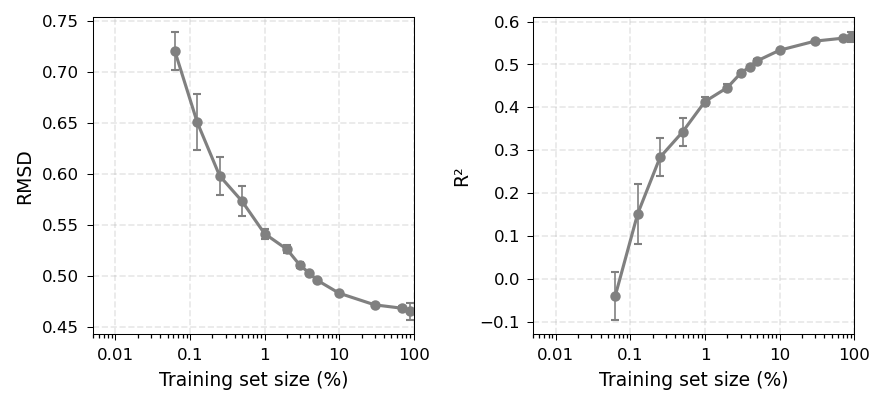

In [24]:
# Set up figure with Nature-style dimensions and resolution for two panels side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2.8), dpi=150)

# Use a professional color palette
color_rmsd = 'gray'# '#0072B2'  # Blue color for RMSD
color_r2 = 'gray' #D55E00'    # Orange/red color for R2

# Plot RMSD scores with error bars (left panel)
ax1.errorbar(stats_df["Training_Size_Fraction"].str.rstrip('%').astype(float), 
             stats_df["RMSD"], 
             yerr=stats_df["RMSD_Error"],
             fmt='o-',
             color=color_rmsd,
             capsize=2,
             markersize=4,
             linewidth=1.5,
             elinewidth=0.8)

# Set log scale for x-axis with proper limits
ax1.set_xscale('log')
ax1.set_xlim(0.005, 100)
# ax1.set_ylim(0, 0.41)  # RMSD typically ranges from 0 to 1

# Customize axes labels with Nature-style formatting
ax1.set_xlabel('Training set size (%)', fontsize=9)
ax1.set_ylabel('RMSD', fontsize=9)

# Customize tick parameters
ax1.tick_params(axis='both', which='major', labelsize=8, direction='out', length=3, width=0.5)
# ax1.set_yticks(np.arange(0, 0.41, 0.1))

# Set x-axis tick labels to show actual values instead of scientific notation
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:g}'))

# Add custom grid (lighter, more subtle)
ax1.grid(True, linestyle='--', alpha=0.3)

# Add a box around the plot
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['left'].set_linewidth(0.5)
ax1.spines['right'].set_linewidth(0.5)
ax1.spines['top'].set_linewidth(0.5)
ax1.spines['bottom'].set_linewidth(0.5)

# Plot R2 scores with error bars (right panel)
ax2.errorbar(stats_df["Training_Size_Fraction"].str.rstrip('%').astype(float), 
             stats_df["R2_Score"], 
             yerr=stats_df["R2_Error"],
             fmt='o-',
             color=color_r2,
             capsize=2,
             markersize=4,
             linewidth=1.5,
             elinewidth=0.8)

# Set log scale for x-axis with proper limits
ax2.set_xscale('log')
ax2.set_xlim(0.005, 100)

# Customize axes labels with Nature-style formatting
ax2.set_xlabel('Training set size (%)', fontsize=9)
ax2.set_ylabel('R²', fontsize=9)

# Customize tick parameters
ax2.tick_params(axis='both', which='major', labelsize=8, direction='out', length=3, width=0.5)
# ax2.set_ylim(-0.1, 1.0)  # R2 typically ranges from 0 to 1 (can be negative for poor fits)

# Set x-axis tick labels to show actual values instead of scientific notation
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:g}'))

# Add custom grid (lighter, more subtle)
ax2.grid(True, linestyle='--', alpha=0.3)

# Add a box around the plot
ax2.spines['top'].set_visible(True)
ax2.spines['right'].set_visible(True)
ax2.spines['left'].set_linewidth(0.5)
ax2.spines['right'].set_linewidth(0.5)
ax2.spines['top'].set_linewidth(0.5)
ax2.spines['bottom'].set_linewidth(0.5)

# Tight layout to optimize space
plt.tight_layout()

# Save high-resolution figure (uncomment if needed)
plt.savefig(PROJECT_PATH  / 'figures/amp_regression/learning_curve_metrics.png', dpi=600, bbox_inches='tight')


In [25]:
 # Split data into training and testing sets
X = df_encoded.drop('Fitness', axis=1)
y = df_encoded['Fitness']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.1, random_state=np.random.randint(1000, 100000))

# Create and train LightGBM model
# Default parameters similar to PyCaret's defaults
model = lgbm.LGBMRegressor(
    objective='regression',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

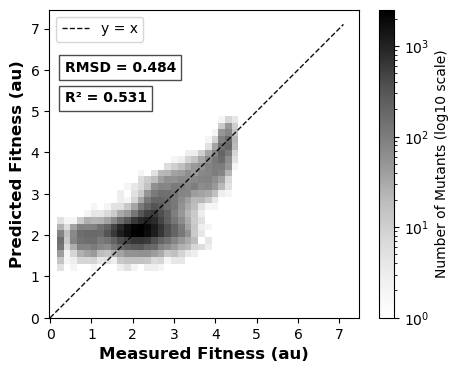

In [26]:
# Create a 2D histogram with specified bin size and axis limits
from matplotlib.colors import LogNorm
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize=(5, 4))

max_fitness = 7
# Define the number of bins and the range
num_bins = 44
bin_range = (0, max_fitness)

# Create bins using np.linspace
bins = np.linspace(bin_range[0], bin_range[1], num_bins)

# Calculate RMSD and R2
rmsd = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Create a 2D histogram with the specified bins
plt.plot([0, max_fitness+.1], [0, max_fitness+.1], 'k--', lw=1, alpha=0.95, label='y = x')
hist, xedges, yedges, img = plt.hist2d(y_test, y_pred, bins=[bins, bins], cmap='Greys', norm=LogNorm())
plt.colorbar(img, label='Number of Mutants (log10 scale)')
plt.grid(False)

# Add RMSD and R2 text labels
plt.text(0.05, 0.8, f'RMSD = {rmsd:.3f}', transform=plt.gca().transAxes, 
         fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
plt.text(0.05, 0.7, f'R² = {r2:.3f}', transform=plt.gca().transAxes, 
         fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

plt.xlim(0, max_fitness)
plt.ylim(0, max_fitness)
plt.xticks(range(0, max_fitness+1, 1))
plt.yticks(range(0, max_fitness+1, 1))
plt.xlabel('Measured Fitness (au)',fontweight='bold', fontsize=12)
plt.ylabel('Predicted Fitness (au)',fontweight='bold', fontsize=12)
plt.legend()
plt.axis('equal')

# Save figure with high resolution
plt.savefig(PROJECT_PATH / 'figures/amp_regression/fitness_prediction_2d_histogram.png', dpi=600, bbox_inches='tight')

Training set residuals - Mean: 0.0000, Std: 0.4243
Test set residuals - Mean: 0.0080, Std: 0.4837


<Figure size 800x550 with 0 Axes>

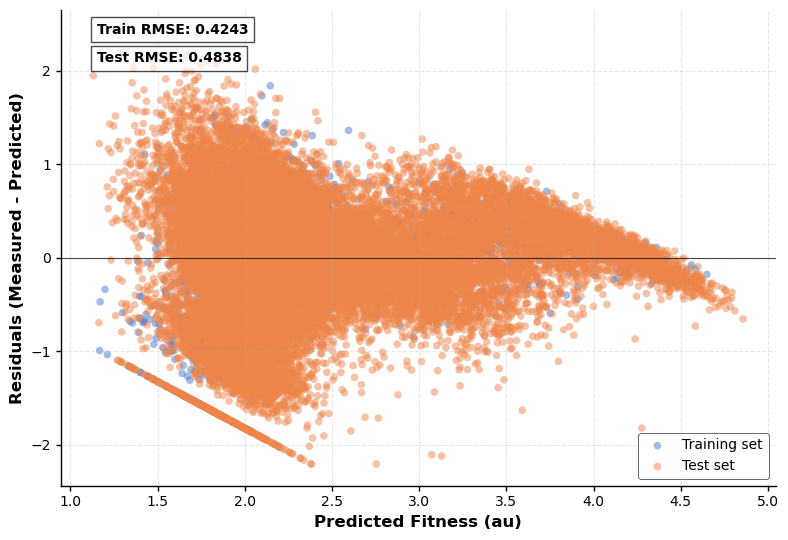

In [27]:
# Calculate residuals for train and test sets
y_train_pred = model.predict(X_train)
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_pred

# Create a publication-quality residual plot
plt.figure(figsize=(8, 5.5))
fig, ax = plt.subplots(figsize=(8, 5.5))

# Plot train and test residuals with different colors
ax.scatter(y_train_pred, train_residuals, s=30, alpha=0.5, color='#4878D0', 
           edgecolor='none', label='Training set')
ax.scatter(y_pred, test_residuals, s=30, alpha=0.5, color='#EE854A', 
           edgecolor='none', label='Test set')

# Add a horizontal line at y=0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.7)

# Calculate RMSE for both sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Add RMSE text annotations
ax.text(0.05, 0.95, f'Train RMSE: {train_rmse:.4f}', transform=ax.transAxes,
        fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))
ax.text(0.05, 0.89, f'Test RMSE: {test_rmse:.4f}', transform=ax.transAxes,
        fontsize=10, fontweight='bold', bbox=dict(facecolor='white', alpha=0.7))

# Style the plot for Nature journal quality
ax.set_xlabel('Predicted Fitness (au)', fontsize=12, fontweight='bold')
ax.set_ylabel('Residuals (Measured - Predicted)', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=10, width=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Set axis limits
# ax.set_xlim(0, 1.1)
y_range = max(abs(train_residuals.min()), abs(train_residuals.max()), 
              abs(test_residuals.min()), abs(test_residuals.max()))
# ax.set_ylim(-y_range*1.1, y_range*1.1)

# Add legend with custom styling
legend = ax.legend(frameon=True, fontsize=10, loc='lower right')
legend.get_frame().set_linewidth(0.5)
legend.get_frame().set_edgecolor('black')

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.3)
# ax.set_xlim([0,1.1])
plt.tight_layout()

# Display summary statistics of residuals
print(f"Training set residuals - Mean: {train_residuals.mean():.4f}, Std: {train_residuals.std():.4f}")
print(f"Test set residuals - Mean: {test_residuals.mean():.4f}, Std: {test_residuals.std():.4f}")

In [28]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Assuming model is trained and you have X_test, y_test
result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()[::-1]

/home2/s414024/micromamba/envs/lgbm312/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/s414024/micromamba/envs/lgbm312/lib/python3.13/site-packages/numpy/_core/_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_61244/2481904703.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(plot_data, vert=False, labels=plot_labels)


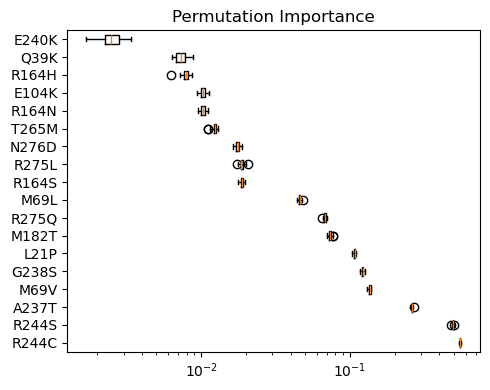

In [29]:
# Plot
# Get top N features
N = 19
top_N_idx = sorted_idx[:N]
# Get the rest of the features and combine their importance
rest_idx = sorted_idx[N:]
rest_importances = result.importances[rest_idx]

# Calculate mean importance for the rest of features
rest_mean_importance = np.mean(rest_importances, axis=0)


# Prepare data for plotting - ensure dimensions match
top_features_data = result.importances[top_N_idx].T  # Shape: (n_repeats, 9)
rest_features_data = rest_mean_importance.reshape(-1, 1)  # Shape: (n_repeats, 1)

# Combine the data for plotting with matching dimensions
if len(rest_idx) > 0:
    plot_labels = list(X_test.columns[top_N_idx]) + [f"Sum of {len(rest_idx)} features"]
    plot_data = np.concatenate([top_features_data, rest_features_data], axis=1)
else:
    plot_labels = list(X_test.columns[top_N_idx])
    plot_data = top_features_data

# Plot the boxplot
plt.figure(figsize=(5, 4))
plt.boxplot(plot_data, vert=False, labels=plot_labels)
plt.xscale('log')
plt.title("Permutation Importance")
plt.tight_layout()

# Save the figure
plt.savefig(PROJECT_PATH / 'figures/amp_regression/permutation_importance.png', dpi=600, bbox_inches='tight')

In [30]:
from __future__ import annotations

import warnings
from typing import Literal

import matplotlib
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd
import scipy.cluster
import scipy.sparse
import scipy.spatial
from matplotlib.figure import Figure
from packaging import version
from scipy.stats import gaussian_kde

from shap.utils import safe_isinstance
from shap import Explanation
from shap.plots import colors
from shap.plots._labels import labels
from shap.plots._utils import (
    convert_color,
    convert_ordering,
    get_sort_order,
    merge_nodes,
    sort_inds,
)
from shap import Cohorts, Explanation
from shap.utils import format_value, ordinal_str
from shap.utils._exceptions import DimensionError
from shap.plots._style import get_style
from shap.plots._utils import convert_ordering, dendrogram_coords, get_sort_order, merge_nodes, sort_inds

def beeswarm(
    shap_values: Explanation,
    max_display: int | None = 10,
    order=Explanation.abs.mean(0),  # type: ignore
    clustering=None,
    cluster_threshold=0.5,
    color=None,
    axis_color="#333333",
    alpha: float = 1.0,
    ax: pl.Axes | None = None,
    show: bool = True,
    log_scale: bool = False,
    color_bar: bool = True,
    s: float = 16,
    plot_size: Literal["auto"] | float | tuple[float, float] | None = "auto",
    color_bar_label: str = labels["FEATURE_VALUE"],
    group_remaining_features: bool = True,
):
    """Create a SHAP beeswarm plot, colored by feature values when they are provided.

    Parameters
    ----------
    shap_values : Explanation
        This is an :class:`.Explanation` object containing a matrix of SHAP values
        (# samples x # features).

    max_display : int
        How many top features to include in the plot (default is 10, or 7 for
        interaction plots).

    ax: matplotlib Axes
        Axes object to draw the plot onto, otherwise uses the current Axes.

    show : bool
        Whether :external+mpl:func:`matplotlib.pyplot.show()` is called before returning.
        Setting this to ``False`` allows the plot to be customized further
        after it has been created, returning the current axis via
        :external+mpl:func:`matplotlib.pyplot.gca()`.

    color_bar : bool
        Whether to draw the color bar (legend).

    s : float
        What size to make the markers. For further information, see ``s`` in
        :external+mpl:func:`matplotlib.pyplot.scatter`.

    plot_size : "auto" (default), float, (float, float), or None
        What size to make the plot. By default, the size is auto-scaled based on the
        number of features that are being displayed. Passing a single float will cause
        each row to be that many inches high. Passing a pair of floats will scale the
        plot by that number of inches. If ``None`` is passed, then the size of the
        current figure will be left unchanged. If ``ax`` is not ``None``, then passing
        ``plot_size`` will raise a :exc:`ValueError`.

    group_remaining_features: bool
        If there are more features than ``max_display``, then plot a row representing
        the sum of SHAP values of all remaining features. Default True.

    Returns
    -------
    ax: matplotlib Axes
        Returns the :external+mpl:class:`~matplotlib.axes.Axes` object with the plot drawn onto it. Only
        returned if ``show=False``.

    Examples
    --------
    See `beeswarm plot examples <https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html>`_.

    """
    if not isinstance(shap_values, Explanation):
        emsg = "The beeswarm plot requires an `Explanation` object as the `shap_values` argument."
        raise TypeError(emsg)

    sv_shape = shap_values.shape
    if len(sv_shape) == 1:
        emsg = (
            "The beeswarm plot does not support plotting a single instance, please pass "
            "an explanation matrix with many instances!"
        )
        raise ValueError(emsg)
    elif len(sv_shape) > 2:
        emsg = (
            "The beeswarm plot does not support plotting explanations with instances that have more than one dimension!"
        )
        raise ValueError(emsg)

    if ax and plot_size:
        emsg = (
            "The beeswarm plot does not support passing an axis and adjusting the plot size. "
            "To adjust the size of the plot, set plot_size to None and adjust the size on the original figure the axes was part of"
        )
        raise ValueError(emsg)

    shap_exp = shap_values
    # we make a copy here, because later there are places that might modify this array
    values = np.copy(shap_exp.values)
    features = shap_exp.data
    if scipy.sparse.issparse(features):
        features = features.toarray()
    feature_names = shap_exp.feature_names
    # if out_names is None: # TODO: waiting for slicer support
    #     out_names = shap_exp.output_names

    order = convert_ordering(order, values)

    # default color:
    if color is None:
        if features is not None:
            color = colors.red_blue
        else:
            color = colors.blue_rgb
    color = convert_color(color)

    idx2cat = None
    # convert from a DataFrame or other types
    if isinstance(features, pd.DataFrame):
        if feature_names is None:
            feature_names = features.columns
        # feature index to category flag
        idx2cat = features.dtypes.astype(str).isin(["object", "category"]).tolist()
        features = features.values
    elif isinstance(features, list):
        if feature_names is None:
            feature_names = features
        features = None
    elif (features is not None) and len(features.shape) == 1 and feature_names is None:
        feature_names = features
        features = None

    num_features = values.shape[1]

    if features is not None:
        shape_msg = "The shape of the shap_values matrix does not match the shape of the provided data matrix."
        if num_features - 1 == features.shape[1]:
            shape_msg += (
                " Perhaps the extra column in the shap_values matrix is the "
                "constant offset? If so, just pass shap_values[:,:-1]."
            )
            raise ValueError(shape_msg)
        if num_features != features.shape[1]:
            raise ValueError(shape_msg)

    if feature_names is None:
        feature_names = np.array([labels["FEATURE"] % str(i) for i in range(num_features)])

    if ax is None:
        ax = pl.gca()
    fig = ax.get_figure()
    assert isinstance(fig, Figure)  # type narrowing for mypy

    if log_scale:
        ax.set_xscale("symlog")

    if clustering is None:
        partition_tree = getattr(shap_values, "clustering", None)
        if partition_tree is not None and partition_tree.var(0).sum() == 0:
            partition_tree = partition_tree[0]
        else:
            partition_tree = None
    elif clustering is False:
        partition_tree = None
    else:
        partition_tree = clustering

    if partition_tree is not None:
        if partition_tree.shape[1] != 4:
            emsg = (
                "The clustering provided by the Explanation object does not seem to "
                "be a partition tree (which is all shap.plots.bar supports)!"
            )
            raise ValueError(emsg)

    # determine how many top features we will plot
    if max_display is None:
        max_display = len(feature_names)
    num_features = min(max_display, len(feature_names))

    # iteratively merge nodes until we can cut off the smallest feature values to stay within
    # num_features without breaking a cluster tree
    orig_inds = [[i] for i in range(len(feature_names))]
    orig_values = values.copy()
    while True:
        feature_order = convert_ordering(order, Explanation(np.abs(values)))
        if partition_tree is not None:
            # compute the leaf order if we were to show (and so have the ordering respect) the whole partition tree
            clust_order = sort_inds(partition_tree, np.abs(values))

            # now relax the requirement to match the partition tree ordering for connections above cluster_threshold
            dist = scipy.spatial.distance.squareform(scipy.cluster.hierarchy.cophenet(partition_tree))
            feature_order = get_sort_order(dist, clust_order, cluster_threshold, feature_order)

            # if the last feature we can display is connected in a tree the next feature then we can't just cut
            # off the feature ordering, so we need to merge some tree nodes and then try again.
            if (
                max_display < len(feature_order)
                and dist[feature_order[max_display - 1], feature_order[max_display - 2]] <= cluster_threshold
            ):
                # values, partition_tree, orig_inds = merge_nodes(values, partition_tree, orig_inds)
                partition_tree, ind1, ind2 = merge_nodes(np.abs(values), partition_tree)
                for _ in range(len(values)):
                    values[:, ind1] += values[:, ind2]
                    values = np.delete(values, ind2, 1)
                    orig_inds[ind1] += orig_inds[ind2]
                    del orig_inds[ind2]
            else:
                break
        else:
            break

    # here we build our feature names, accounting for the fact that some features might be merged together
    feature_inds = feature_order[:max_display]
    feature_names_new = []
    for inds in orig_inds:
        if len(inds) == 1:
            feature_names_new.append(feature_names[inds[0]])
        elif len(inds) <= 2:
            feature_names_new.append(" + ".join([feature_names[i] for i in inds]))
        else:
            max_ind = np.argmax(np.abs(orig_values).mean(0)[inds])
            feature_names_new.append(f"{feature_names[inds[max_ind]]} + {len(inds) - 1} other features")
    feature_names = feature_names_new

    # see how many individual (vs. grouped at the end) features we are plotting
    include_grouped_remaining = num_features < len(values[0]) and group_remaining_features
    if include_grouped_remaining:
        num_cut = np.sum([len(orig_inds[feature_order[i]]) for i in range(num_features - 1, len(values[0]))])
        values[:, feature_order[num_features - 1]] = np.sum(
            [values[:, feature_order[i]] for i in range(num_features - 1, len(values[0]))], 0
        )

    # build our y-tick labels
    yticklabels = [feature_names[i] for i in feature_inds]
    if include_grouped_remaining:
        yticklabels[-1] = f"Sum of {num_cut} other features"

    row_height = 0.5
    if plot_size == "auto":
        fig.set_size_inches(8, min(len(feature_order), max_display) * row_height + 1.5)
    elif isinstance(plot_size, (list, tuple)):
        fig.set_size_inches(plot_size[0], plot_size[1])
    elif plot_size is not None:
        fig.set_size_inches(8, min(len(feature_order), max_display) * plot_size + 1.5)
    ax.axvline(x=0, color="#999999", zorder=-1)

    # Track if any binary features were found
    binary_features_found = False
    legend_added = False

    # make the beeswarm dots
    for pos, i in enumerate(reversed(feature_inds)):
        ax.axhline(y=pos, color="#cccccc", lw=0.5, dashes=(1, 5), zorder=-1)
        shaps = values[:, i]
        fvalues = None if features is None else features[:, i]
        f_inds = np.arange(len(shaps))
        np.random.shuffle(f_inds)
        if fvalues is not None:
            fvalues = fvalues[f_inds]
        shaps = shaps[f_inds]
        colored_feature = True
        try:
            if idx2cat is not None and idx2cat[i]:  # check categorical feature
                colored_feature = False
            else:
                fvalues = np.array(fvalues, dtype=np.float64)  # make sure this can be numeric
        except Exception:
            colored_feature = False
        N = len(shaps)
        # hspacing = (np.max(shaps) - np.min(shaps)) / 200
        # curr_bin = []
        nbins = 100
        quant = np.round(nbins * (shaps - np.min(shaps)) / (np.max(shaps) - np.min(shaps) + 1e-8))
        inds_ = np.argsort(quant + np.random.randn(N) * 1e-6)
        layer = 0
        last_bin = -1
        ys = np.zeros(N)
        for ind in inds_:
            if quant[ind] != last_bin:
                layer = 0
            ys[ind] = np.ceil(layer / 2) * ((layer % 2) * 2 - 1)
            layer += 1
            last_bin = quant[ind]
        ys *= 0.9 * (row_height / np.max(ys + 1))

        # Check if we have binary features (0 or 1)
        if fvalues is not None and colored_feature is True:
            is_binary = np.all(np.isin(np.unique(fvalues), [0, 1]))
            
            if is_binary:
                # For binary features, use a legend instead of colorbar
                binary_features_found = True
                wildtype_mask = (fvalues == 0)
                mutated_mask = (fvalues == 1)
                
                # Use black for wildtype and a second color for mutated
                mutated_color = 'red'#'#008080'  # A nice blue color
                
                s = 4
                alpha = 0.5
                # Plot wildtype
                if np.any(wildtype_mask):
                    ax.scatter(
                        shaps[wildtype_mask],
                        pos + ys[wildtype_mask],
                        color='black',
                        s=s,
                        alpha=alpha,
                        linewidth=0,
                        zorder=3,
                        rasterized=len(shaps) > 50000,
                        label='Wildtype' if not legend_added else ""
                    )
                
                # Plot mutated
                if np.any(mutated_mask):
                    ax.scatter(
                        shaps[mutated_mask],
                        pos + ys[mutated_mask],
                        color=mutated_color,
                        s=s,
                        alpha=1,
                        linewidth=0,
                        zorder=5,
                        rasterized=len(shaps) > 50000,
                        label='Mutated' if not legend_added else ""
                    )
                
                # Add the legend just once
                if not legend_added and color_bar:
                    legend_added = True
            elif safe_isinstance(color, "matplotlib.colors.Colormap"):
                # For non-binary features, use the original colormap approach
                # trim the color range, but prevent the color range from collapsing
                vmin = np.nanpercentile(fvalues, 5)
                vmax = np.nanpercentile(fvalues, 95)
                if vmin == vmax:
                    vmin = np.nanpercentile(fvalues, 1)
                    vmax = np.nanpercentile(fvalues, 99)
                    if vmin == vmax:
                        vmin = np.min(fvalues)
                        vmax = np.max(fvalues)
                if vmin > vmax:  # fixes rare numerical precision issues
                    vmin = vmax

                # plot the nan fvalues in the interaction feature as grey
                nan_mask = np.isnan(fvalues)
                ax.scatter(
                    shaps[nan_mask],
                    pos + ys[nan_mask],
                    color="#777777",
                    s=s,
                    alpha=alpha,
                    linewidth=0,
                    zorder=3,
                    rasterized=len(shaps) > 500,
                )

                # plot the non-nan fvalues colored by the trimmed feature value
                cvals = fvalues[np.invert(nan_mask)].astype(np.float64)
                cvals_imp = cvals.copy()
                cvals_imp[np.isnan(cvals)] = (vmin + vmax) / 2.0
                cvals[cvals_imp > vmax] = vmax
                cvals[cvals_imp < vmin] = vmin
                ax.scatter(
                    shaps[np.invert(nan_mask)],
                    pos + ys[np.invert(nan_mask)],
                    cmap=color,
                    vmin=vmin,
                    vmax=vmax,
                    s=s,
                    c=cvals,
                    alpha=alpha,
                    linewidth=0,
                    zorder=3,
                    rasterized=len(shaps) > 500,
                )
        else:
            if safe_isinstance(color, "matplotlib.colors.Colormap") and hasattr(color, "colors"):
                color = color.colors
            ax.scatter(
                shaps,
                pos + ys,
                s=s,
                alpha=alpha,
                linewidth=0,
                zorder=3,
                color=color if colored_feature else "#777777",
                rasterized=len(shaps) > 500,
            )
        
        if binary_features_found:
            # Add legend only if it's not already there
            if not ax.get_legend():
                # Create dummy larger points for legend
                legend_elements = [
                    pl.Line2D([0], [0], marker='o', color='black', label='Wildtype',
                        markerfacecolor='black', markersize=8, linestyle='None'),
                    pl.Line2D([0], [0], marker='o', color=mutated_color, label='Mutated',
                        markerfacecolor=mutated_color, markersize=8, linestyle='None')
                ]
                leg = ax.legend(handles=legend_elements, loc='lower right', frameon=True)
                leg.get_frame().set_linewidth(0.5)
        elif safe_isinstance(color, "matplotlib.colors.Colormap"):
            # Use colorbar for continuous features 
            import matplotlib.cm as cm
            m = cm.ScalarMappable(cmap=color)
            m.set_array([0, 1])
            cb = fig.colorbar(m, ax=ax, ticks=[0, 1], aspect=80)
            cb.set_ticklabels([labels["FEATURE_VALUE_LOW"], labels["FEATURE_VALUE_HIGH"]])
            cb.set_label(color_bar_label, size=12, labelpad=0)
            cb.ax.tick_params(labelsize=11, length=0)
            cb.set_alpha(1)
            cb.outline.set_visible(False)

    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("none")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.tick_params(color=axis_color, labelcolor=axis_color)
    ax.set_yticks(range(len(feature_inds)), list(reversed(yticklabels)), fontsize=13)
    ax.tick_params("y", length=20, width=0.5, which="major")
    ax.tick_params("x", labelsize=11)
    ax.set_ylim(-1, len(feature_inds))
    #ax.set_xlabel(labels["VALUE"], fontsize=13)
    ax.set_xlabel("SHAP value", fontsize=13)
    if show:
        pl.show()
    else:
        return ax

def bar(
    shap_values,
    max_display=10,
    order=Explanation.abs,
    clustering=None,
    clustering_cutoff=0.5,
    show_data="auto",
    ax=None,
    show=True,
):
    """Create a bar plot of a set of SHAP values.

    Parameters
    ----------
    shap_values : shap.Explanation or shap.Cohorts or dictionary of shap.Explanation objects
        Passing a multi-row :class:`.Explanation` object creates a global
        feature importance plot.

        Passing a single row of an explanation (i.e. ``shap_values[0]``) creates
        a local feature importance plot.

        Passing a dictionary of Explanation objects will create a multiple-bar
        plot with one bar type for each of the cohorts represented by the
        explanation objects.
    max_display : int
        How many top features to include in the bar plot (default is 10).
    order : OpChain or numpy.ndarray
        A function that returns a sort ordering given a matrix of SHAP values
        and an axis, or a direct sample ordering given as a ``numpy.ndarray``.

        By default, take the absolute value.
    clustering: np.ndarray or None
        A partition tree, as returned by :func:`shap.utils.hclust`
    clustering_cutoff: float
        Controls how much of the clustering structure is displayed.
    show_data: bool or str
        Controls if data values are shown as part of the y tick labels. If
        "auto", we show the data only when there are no transforms.
    ax: matplotlib Axes
        Axes object to draw the plot onto, otherwise uses the current Axes.
    show : bool
        Whether :external+mpl:func:`matplotlib.pyplot.show()` is called before returning.
        Setting this to ``False`` allows the plot
        to be customized further after it has been created.

    Returns
    -------
    ax: matplotlib Axes
        Returns the :external+mpl:class:`~matplotlib.axes.Axes` object with the plot drawn onto it. Only
        returned if ``show=False``.

    Examples
    --------
    See `bar plot examples <https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html>`_.

    """
    postive_color = "gray"
    
    style = get_style()
    # convert Explanation objects to dictionaries
    if isinstance(shap_values, Explanation):
        cohorts = {"": shap_values}
    elif isinstance(shap_values, Cohorts):
        cohorts = shap_values.cohorts
    elif isinstance(shap_values, dict):
        cohorts = shap_values
    else:
        emsg = (
            "The shap_values argument must be an Explanation object, Cohorts "
            "object, or dictionary of Explanation objects!"
        )
        raise TypeError(emsg)

    # unpack our list of Explanation objects we need to plot
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i, exp in enumerate(cohort_exps):
        if not isinstance(exp, Explanation):
            emsg = (
                "The shap_values argument must be an Explanation object, Cohorts "
                "object, or dictionary of Explanation objects!"
            )
            raise TypeError(emsg)

        if len(exp.shape) == 2:
            # collapse the Explanation arrays to be of shape (#features,)
            cohort_exps[i] = exp.abs.mean(0)
        if cohort_exps[i].shape != cohort_exps[0].shape:
            emsg = "When passing several Explanation objects, they must all have the same number of feature columns!"
            raise DimensionError(emsg)
        # TODO: check other attributes for equality? like feature names perhaps? probably clustering as well.

    # unpack the Explanation object
    features = cohort_exps[0].display_data if cohort_exps[0].display_data is not None else cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    if clustering is None:
        partition_tree = getattr(cohort_exps[0], "clustering", None)
    elif clustering is False:
        partition_tree = None
    else:
        partition_tree = clustering
    if partition_tree is not None:
        if len(partition_tree.shape) != 2 or partition_tree.shape[1] != 4:
            raise TypeError(
                "The clustering provided by the Explanation object does not seem to be a "
                "partition tree, which is all shap.plots.bar supports."
            )
    op_history: list[OpHistoryItem] = cohort_exps[0].op_history
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])

    if len(values[0]) == 0:
        raise ValueError("The passed Explanation is empty, so there is nothing to plot.")

    # we show the data on auto only when there are no transforms (excluding getitem calls)
    if show_data == "auto":
        transforms = [op for op in op_history if op.name != "__getitem__"]
        show_data = len(transforms) == 0

    # TODO: Rather than just show the "1st token", "2nd token", etc. it would be better to show the "Instance 0's 1st but", etc
    if issubclass(type(feature_names), str):
        feature_names = [ordinal_str(i) + " " + feature_names for i in range(len(values[0]))]

    # build our auto xlabel based on the transform history of the Explanation object
    xlabel = "SHAP value"
    for op in op_history:
        if op.name == "abs":
            xlabel = f"|{xlabel}|"
        elif op.name == "__getitem__":
            pass  # no need for slicing to effect our label, it will be used later to find the sizes of cohorts
        else:
            xlabel = f"{op.name}({xlabel})"

    # find how many instances are in each cohort (if they were created from an Explanation object)
    cohort_sizes = []
    for exp in cohort_exps:
        for op in exp.op_history:
            if op.collapsed_instances:  # see if this if the first op to collapse the instances
                cohort_sizes.append(op.prev_shape[0])
                break

    # unwrap any pandas series
    if isinstance(features, pd.Series):
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    # ensure we at least have default feature names
    if feature_names is None:
        feature_names = np.array([labels["FEATURE"] % str(i) for i in range(len(values[0]))])

    # determine how many top features we will plot
    if max_display is None:
        max_display = len(feature_names)
    num_features = min(max_display, len(values[0]))
    max_display = min(max_display, num_features)

    # iteratively merge nodes until we can cut off the smallest feature values to stay within
    # num_features without breaking a cluster tree
    orig_inds = [[i] for i in range(len(values[0]))]
    orig_values = values.copy()
    while True:
        feature_order = np.argsort(
            np.mean([np.argsort(convert_ordering(order, Explanation(values[i]))) for i in range(values.shape[0])], 0)
        )
        if partition_tree is not None:
            # compute the leaf order if we were to show (and so have the ordering respect) the whole partition tree
            clust_order = sort_inds(partition_tree, np.abs(values).mean(0))

            # now relax the requirement to match the partition tree ordering for connections above clustering_cutoff
            dist = scipy.spatial.distance.squareform(scipy.cluster.hierarchy.cophenet(partition_tree))
            feature_order = get_sort_order(dist, clust_order, clustering_cutoff, feature_order)

            # if the last feature we can display is connected in a tree the next feature then we can't just cut
            # off the feature ordering, so we need to merge some tree nodes and then try again.
            if (
                max_display < len(feature_order)
                and dist[feature_order[max_display - 1], feature_order[max_display - 2]] <= clustering_cutoff
            ):
                # values, partition_tree, orig_inds = merge_nodes(values, partition_tree, orig_inds)
                partition_tree, ind1, ind2 = merge_nodes(np.abs(values).mean(0), partition_tree)
                for _ in range(len(values)):
                    values[:, ind1] += values[:, ind2]
                    values = np.delete(values, ind2, 1)
                    orig_inds[ind1] += orig_inds[ind2]
                    del orig_inds[ind2]
            else:
                break
        else:
            break

    # here we build our feature names, accounting for the fact that some features might be merged together
    feature_inds = feature_order[:max_display]
    y_pos = np.arange(len(feature_inds), 0, -1)
    feature_names_new = []
    for inds in orig_inds:
        if len(inds) == 1:
            feature_names_new.append(feature_names[inds[0]])
        else:
            full_print = " + ".join([feature_names[i] for i in inds])
            if len(full_print) <= 40:
                feature_names_new.append(full_print)
            else:
                max_ind = np.argmax(np.abs(orig_values).mean(0)[inds])
                feature_names_new.append(f"{feature_names[inds[max_ind]]} + {len(inds) - 1} other features")
    feature_names = feature_names_new

    # see how many individual (vs. grouped at the end) features we are plotting
    if num_features < len(values[0]):
        num_cut = np.sum([len(orig_inds[feature_order[i]]) for i in range(num_features - 1, len(values[0]))])
        values[:, feature_order[num_features - 1]] = np.sum(
            [values[:, feature_order[i]] for i in range(num_features - 1, len(values[0]))], 0
        )

    # build our y-tick labels
    yticklabels = []
    for i in feature_inds:
        if features is not None and show_data:
            yticklabels.append(format_value(features[i], "%0.03f") + " = " + feature_names[i])
        else:
            yticklabels.append(feature_names[i])
    if num_features < len(values[0]):
        yticklabels[-1] = f"Sum of {num_cut} other features"

    if ax is None:
        ax = pl.gca()
        # Only modify the figure size if ax was not passed in
        # compute our figure size based on how many features we are showing
        fig = pl.gcf()
        row_height = 0.5
        fig.set_size_inches(8, num_features * row_height * np.sqrt(len(values)) + 1.5)

    # if negative values are present then we draw a vertical line to mark 0, otherwise the axis does this for us...
    negative_values_present = np.sum(values[:, feature_order[:num_features]] < 0) > 0
    if negative_values_present:
        ax.axvline(0, 0, 1, color="#000000", linestyle="-", linewidth=1, zorder=1)

    # draw the bars
    patterns = (None, "\\\\", "++", "xx", "////", "*", "o", "O", ".", "-")
    total_width = 0.7
    bar_width = total_width / len(values)
    for i in range(len(values)):
        ypos_offset = -((i - len(values) / 2) * bar_width + bar_width / 2)
        ax.barh(
            y_pos + ypos_offset,
            values[i, feature_inds],
            bar_width,
            align="center",
            color=[
                style.primary_color_negative if values[i, feature_inds[j]] <= 0 else postive_color
                for j in range(len(y_pos))
            ],
            hatch=patterns[i],
            edgecolor=(1, 1, 1, 0.8),
            label=f"{cohort_labels[i]} [{cohort_sizes[i] if i < len(cohort_sizes) else None}]",
        )

    # draw the yticks (the 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks)
    ax.set_yticks(list(y_pos) + list(y_pos + 1e-8), yticklabels + [t.split("=")[-1] for t in yticklabels], fontsize=13)

    xlen = ax.get_xlim()[1] - ax.get_xlim()[0]
    # xticks = ax.get_xticks()
    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    width = bbox.width
    bbox_to_xscale = xlen / width

    for i in range(len(values)):
        ypos_offset = -((i - len(values) / 2) * bar_width + bar_width / 2)
        for j in range(len(y_pos)):
            ind = feature_order[j]
            if values[i, ind] < 0:
                ax.text(
                    values[i, ind] - (5 / 72) * bbox_to_xscale,
                    y_pos[j] + ypos_offset,
                    format_value(values[i, ind], "%+0.02f"),
                    horizontalalignment="right",
                    verticalalignment="center",
                    color=style.primary_color_negative,
                    fontsize=12,
                )
            else:
                ax.text(
                    values[i, ind] + (5 / 72) * bbox_to_xscale,
                    y_pos[j] + ypos_offset,
                    format_value(values[i, ind], "%+0.02f"),
                    horizontalalignment="left",
                    verticalalignment="center",
                    color=postive_color,
                    fontsize=12,
                )

    # put horizontal lines for each feature row
    for i in range(num_features):
        ax.axhline(i + 1, color="#888888", lw=0.5, dashes=(1, 5), zorder=-1)

    if features is not None:
        features = list(features)

        # try and round off any trailing zeros after the decimal point in the feature values
        for i in range(len(features)):
            try:
                if round(features[i]) == features[i]:
                    features[i] = int(features[i])
            except Exception:
                pass  # features[i] must not be a number

    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("none")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    if negative_values_present:
        ax.spines["left"].set_visible(False)
    ax.tick_params("x", labelsize=11)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    x_buffer = (xmax - xmin) * 0.05

    if negative_values_present:
        ax.set_xlim(xmin - x_buffer, xmax + x_buffer)
    else:
        ax.set_xlim(xmin, xmax + x_buffer)

    # if features is None:
    #     pl.xlabel(labels["GLOBAL_VALUE"], fontsize=13)
    # else:
    ax.set_xlabel(xlabel, fontsize=13)

    if len(values) > 1:
        ax.legend(fontsize=12)

    # color the y tick labels that have the feature values as gray
    # (these fall behind the black ones with just the feature name)
    tick_labels = ax.yaxis.get_majorticklabels()
    for i in range(num_features):
        tick_labels[i].set_color(style.tick_labels_color)

    # draw a dendrogram if we are given a partition tree
    if partition_tree is not None:
        # compute the dendrogram line positions based on our current feature order
        feature_pos = np.argsort(feature_order)
        ylines, xlines = dendrogram_coords(feature_pos, partition_tree)

        # plot the distance cut line above which we don't show tree edges
        xmin, xmax = ax.get_xlim()
        xlines_min, xlines_max = np.min(xlines), np.max(xlines)
        ct_line_pos = (clustering_cutoff / (xlines_max - xlines_min)) * 0.1 * (xmax - xmin) + xmax
        ax.text(
            ct_line_pos + 0.005 * (xmax - xmin),
            (ymax - ymin) / 2,
            "Clustering cutoff = " + format_value(clustering_cutoff, "%0.02f"),
            horizontalalignment="left",
            verticalalignment="center",
            color="#999999",
            fontsize=12,
            rotation=-90,
        )
        line = ax.axvline(ct_line_pos, color="#dddddd", dashes=(1, 1))
        line.set_clip_on(False)

        for xline, yline in zip(xlines, ylines):
            # normalize the x values to fall between 0 and 1
            xv = np.array(xline) / (xlines_max - xlines_min)

            # only draw if we are not going past distance threshold
            if np.array(xline).max() <= clustering_cutoff:
                # only draw if we are not going past the bottom of the plot
                if yline.max() < max_display:
                    lines = ax.plot(xv * 0.1 * (xmax - xmin) + xmax, max_display - np.array(yline), color="#999999")
                    for line in lines:
                        line.set_clip_on(False)

    if show:
        pl.show()
    else:
        return ax


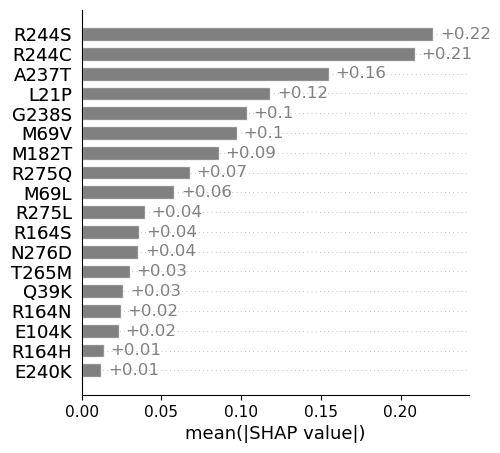

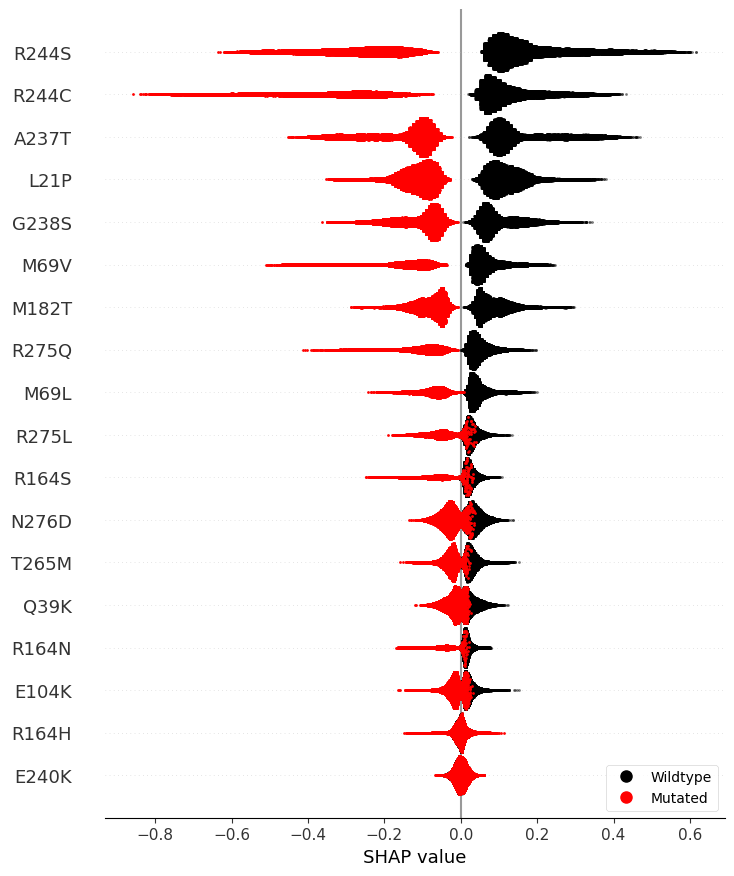

In [31]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

# Global feature importance plot
fig, ax = plt.subplots(figsize=(5, 5))
bar(shap_values, max_display=20, ax=ax)
fig.savefig(PROJECT_PATH / 'figures/amp_regression/shap_feature_importance.png', dpi=600, bbox_inches='tight')

# Detailed feature importance visualization
fig, ax = plt.subplots(figsize=(5, 5))
beeswarm(shap_values, max_display=20)
fig.savefig(PROJECT_PATH / 'figures/amp_regression/shap_beeswarm.png', dpi=600, bbox_inches='tight')


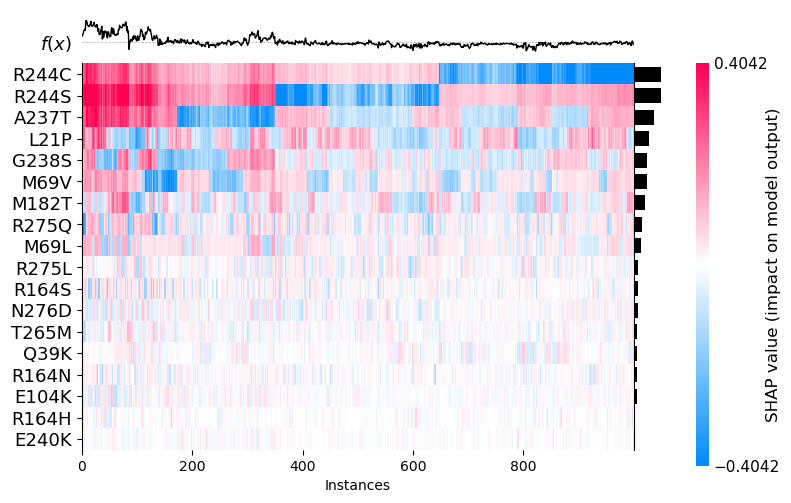

In [32]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)
# Randomly sample 1000 instances from X_test
random_indices = np.random.choice(len(X_test), size=1000, replace=False)
shap_values = explainer(X_test.iloc[random_indices])

# Feature interaction analysis
ax = shap.plots.heatmap(shap_values, max_display=20, show=False)

# Modify the colorbar
cb = ax.figure.axes[-1]  # Get the colorbar axes (last axes in the figure)
cb.set_box_aspect(30)  # Make colorbar thicker

# Increase padding between colorbar and main axes
cb.set_position([cb.get_position().x0, 0.29, cb.get_position().width+10, 0.35])

plt.show()

ax.figure.savefig(PROJECT_PATH / 'figures/amp_regression/shap_interaction_heatmap.png', dpi=600, bbox_inches='tight')

In [33]:
# Create SHAP explainer
explainer = shap.TreeExplainer(model)
# Get the top 2000 instances based on y_test values
top_indices = np.argsort(y_pred)[-553:]  # Get indices of highest y_test values
shap_values = explainer(X_test.iloc[top_indices])

In [34]:
# This is equivalent to how SHAP calculates the order internally
from shap.utils import hclust_ordering

# Get the ordering of instances
instance_order = hclust_ordering(shap_values.values)

# Get first 10 and their features
first_10_examples = X_test.iloc[top_indices[instance_order][:10]]
print("\nTop 10 examples with highest predicted fitness:")
print(first_10_examples)

print(df_genotypes[first_10_examples.index])



Top 10 examples with highest predicted fitness:
       L21P   Q39K   M69L   M69V  E104K  R164H  R164N  R164S  M182T  A237T  \
43238  True   True  False  False  False  False   True  False  False  False   
29414  True  False  False  False  False  False   True  False  False  False   
29378  True  False  False  False  False  False   True  False  False  False   
41474  True   True  False  False  False  False  False  False  False  False   
41510  True   True  False  False  False  False  False  False  False  False   
27686  True  False  False  False  False  False  False  False  False  False   
27650  True  False  False  False  False  False  False  False  False  False   
42626  True   True  False  False  False   True  False  False  False  False   
28802  True  False  False  False  False   True  False  False  False  False   
28838  True  False  False  False  False   True  False  False  False  False   

       G238S  E240K  R244C  R244S  T265M  R275L  R275Q  N276D  
43238  False   True  False  

In [39]:
shap_values.feature_names

['L21P',
 'Q39K',
 'M69L',
 'M69V',
 'E104K',
 'R164H',
 'R164N',
 'R164S',
 'M182T',
 'A237T',
 'G238S',
 'E240K',
 'R244C',
 'R244S',
 'T265M',
 'R275L',
 'R275Q',
 'N276D']

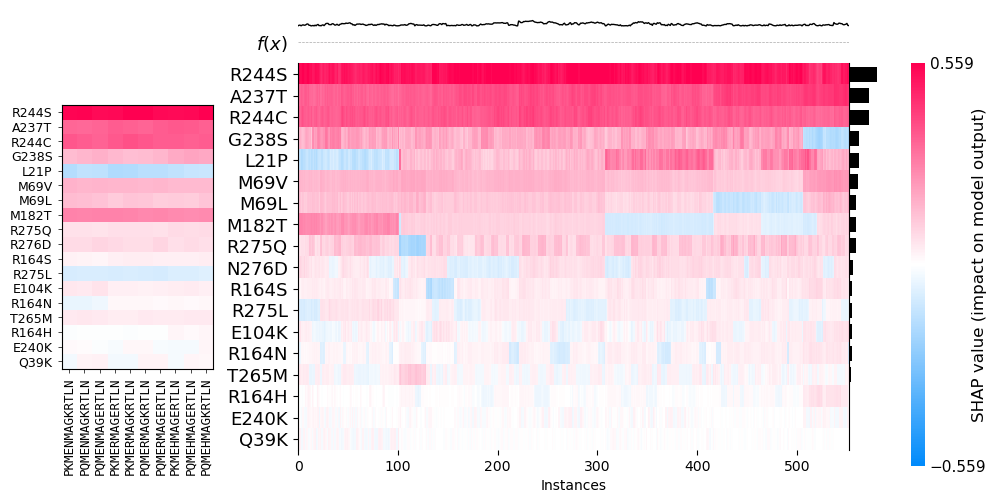

In [43]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle

# Feature interaction analysis
ax = shap.plots.heatmap(shap_values, max_display=20, show=False)

# Modify the colorbar
cb = ax.figure.axes[-1]  # Get the colorbar axes (last axes in the figure)
cb.set_box_aspect(30)    # Make colorbar thicker
cb.set_position([cb.get_position().x0, 0.29, cb.get_position().width+0.01, 0.35])

# --- add a cutout inset zooming into the first 30 instances ---
# grab the heatmap image and its clustered data array
im = ax.images[0]
heatmap_data = im.get_array()

# create inset axes in the upper‐right corner of the main axes
# Fix: provide a 4-tuple (x, y, width, height) for bbox_to_anchor when using relative size
axins = inset_axes(ax, width="50%", height="100%", loc='upper right',
                   bbox_to_anchor=(-0.69, .2, 0.55, .6), bbox_transform=ax.transAxes)
# display the same heatmap data but only first 9 columns
axins.imshow(heatmap_data, aspect='auto', cmap=im.cmap, norm=im.norm)
axins.set_xlim(-.5, 9.5)
# invert y‐axis so rows align with main plot
axins.set_ylim(heatmap_data.shape[0]-0.5, -0.5)

# Add tick labels for better readability
axins.set_xticks(np.arange(0,10))
axins.set_xticklabels(df_genotypes[first_10_examples.index], rotation=90, fontsize=9, fontfamily='monospace')

# Set y-ticks for axins
y_positions = range(heatmap_data.shape[0])
# Use a subset of y positions to avoid overcrowding
yaxis_features = ['R244S','A237T','R244C','G238S','L21P', 'M69V','M69L','M182T','R275Q',
         'R276D','R164S', 'R275L','E104K','R164N', 'T265M','R164H','E240K','Q39K']
axins.set_yticks(range(len(yaxis_features)))
axins.set_yticklabels([feat for feat in yaxis_features], fontsize=9)
axins.tick_params(axis='both', length=3, width=0.5)

# Enhance appearance
axins.spines['top'].set_visible(True)
axins.spines['right'].set_visible(True)
axins.spines['left'].set_visible(True)
axins.spines['bottom'].set_visible(True)

# # Add a rectangle to the main axes to indicate the zoomed (cutout) region
# rect = Rectangle((0.49, -.49), 9, heatmap_data.shape[0]-.1, linewidth=0.75, edgecolor='black', facecolor='none', linestyle='--')
# ax.add_patch(rect)

plt.show()

# Uncomment to save the figure
ax.figure.savefig(PROJECT_PATH / 'figures/amp_regression/shap_interaction_heatmap.png',
                  dpi=600, bbox_inches='tight')

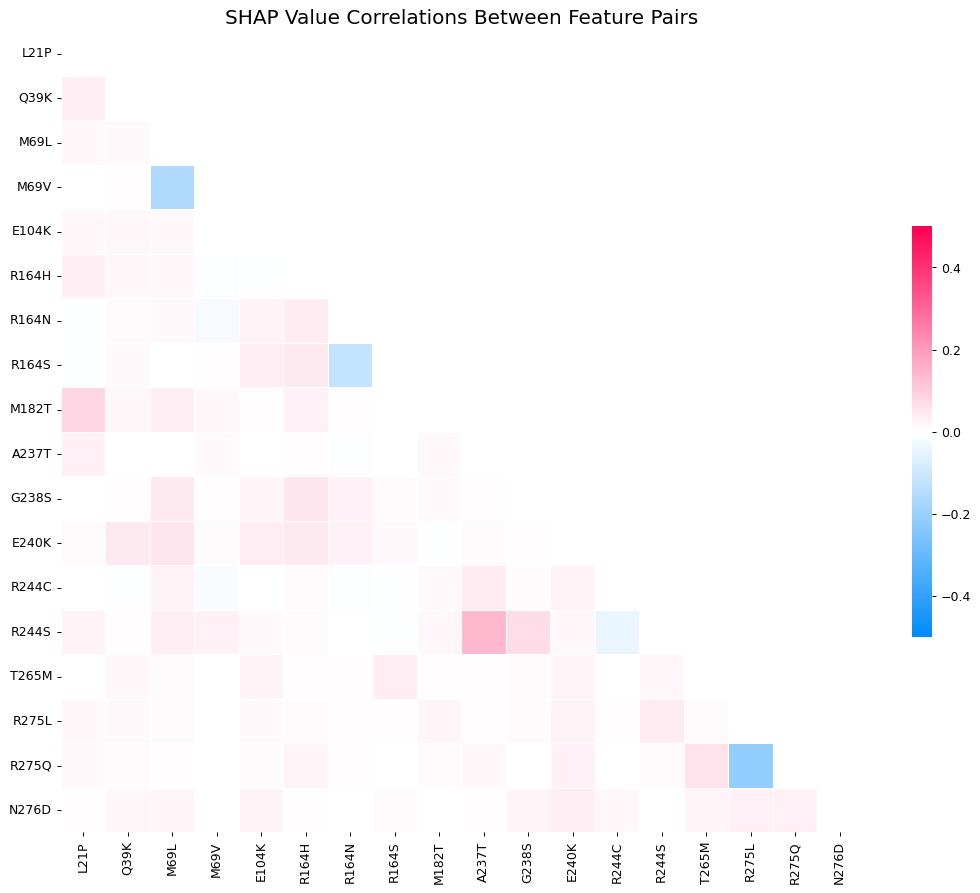

In [44]:
import seaborn as sns

# Use a reasonable sample size for analysis
shap_values = explainer(X_test)

# Convert SHAP values to a DataFrame for correlation analysis
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

# Calculate correlation matrix between SHAP values
shap_corr = shap_df.corr()

# Drop features with NaN correlations
shap_corr = shap_corr.dropna(how='all').dropna(axis=1, how='all')

# Create a correlation heatmap
plt.figure(figsize=(12, 10), dpi=90)
mask = np.triu(np.ones_like(shap_corr, dtype=bool))  # Create mask for upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Create colormap

# Plot the heatmap
sns.heatmap(shap_corr, mask=mask, cmap=shap.plots.colors.red_white_blue, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False)

plt.title('SHAP Value Correlations Between Feature Pairs', fontsize=16)
plt.tight_layout()
plt.savefig(PROJECT_PATH / 'figures/amp_regression/shap_correlation_heatmap.png', dpi=600, bbox_inches='tight')